## Isabelle Tobin's convective aggregation classification

Uses VISST data to derive convective aggregation index

In [51]:
# Load required libraries
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import datetime
from matplotlib import dates
import math
import glob
import os
from skimage import measure
%matplotlib inline
from scipy import interpolate, ndimage
from copy import deepcopy
import cartopy.crs as ccrs

Input time for algorithm to run on

In [52]:
# Input the range of dates and time wanted for the collection of images
year = 2006
start_day = 1
start_month = 1
start_hour = 1
start_minute = 0
start_second = 0

end_month = 3
end_day = 1
end_hour = 1
end_minute = 10
end_second = 00

start_time = datetime.datetime(year,
                               start_month,
                               start_day,
                               start_hour,
                               start_minute,
                               start_second)
end_time = datetime.datetime(year,
                             end_month,
                             end_day,
                             end_hour,
                             end_minute,
                             end_second)
deltatime = end_time - start_time


if(deltatime.seconds > 0 or deltatime.minute > 0):
    no_days = deltatime.days + 1
else:
    no_days = deltatime.days

days = np.arange(0, no_days, 1)
print('We are about to load grid files for ' + str(no_days) + ' days')
data_path = '/home/rjackson/data/visst/'

# Find the list of files for each day
cur_time = start_time

file_list = []
time_list = []
for i in days:
    year_str = "%04d" % cur_time.year
    day_str = "%02d" % cur_time.day
    month_str = "%02d" % cur_time.month
    print('Looking for files with format ' +
          data_path +
          'twpvisstpx04*' +
          year_str +
          month_str +
          day_str +
          '*.cdf')
    data_list = glob.glob(data_path +
                          'twpvisstpx04*' +
                          year_str +
                          month_str +
                          day_str +
                          '*.cdf')
    if(data_list):
        file_list.append(data_list[0])
        time_list.append(cur_time)
        cur_time = cur_time + datetime.timedelta(days=1)

We are about to load grid files for 60 days
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060101*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060102*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060103*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060104*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060105*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060106*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060107*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060108*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060109*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060110*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060111*.cdf
Looking for files with format /home/rjackso

In [53]:
# Convert degrees minutes seconds to decimal
def dms_to_decimal(deg, minutes, seconds):
    return deg+minutes/60+seconds/3600

# Convert seconds to midnight to a string format
def seconds_to_midnight_to_string(time_secs_after_midnight):

    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    temp = datetime.time(int(hours), int(minutes), )
    return temp.strftime('%H%M%S')

def seconds_to_midnight_to_hm(time_secs_after_midnight):
    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    return hours, minutes

Load image data. Mask out all regions with Tb > 240 K to only include convective regions as defined by Tobin et al. (2012)

[ 125.04000092  125.04000092  125.04000092 ...,  135.97999573  135.97000122
  135.97000122]
Domain:125.0 136.0-17.0 -5.0
(269, 245)


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in greater


/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


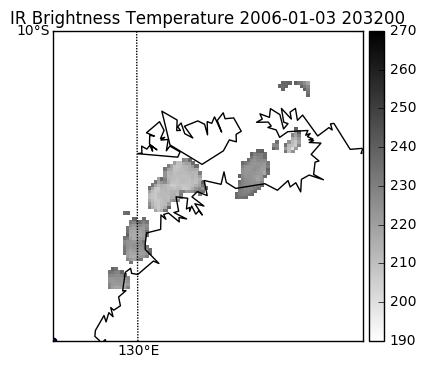

In [54]:
i = 2
cdf_data = Dataset(file_list[i], mode='r')

# Load lat, lon, and time parameters - try statement for 24-hourly data, except for daily data

Latitude = cdf_data.variables['latitude']
Longitude = cdf_data.variables['longitude']
Time = cdf_data.variables['image_times']
NumPixels = cdf_data.variables['image_numpix']

# Load brightness temperature
IRBrightness = cdf_data.variables['temperature_ir']

frame = 20

j = frame

convective_regions = IRBrightness[:] < 240
Darwin_Lat = dms_to_decimal(-12, 25, 28.56)
Darwin_Lon = dms_to_decimal(130, 53, 29.75)

cpol_latitude = -12.249166
cpol_longitude = 131.04445

# Get Lat and Lon for specific frame
Lat = Latitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
Lon = Longitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
print(Lon)

# Set up projection
plt.clf()
m = Basemap(width=500000, height=500000,
            resolution='l', projection='stere',
            lat_0=cpol_latitude,
            lon_0=cpol_longitude)

xi, yi = m(Lon, Lat)
darwin_x, darwin_y = m(cpol_latitude, cpol_longitude)

# Regrid data to 2D
x,y = np.meshgrid(np.arange(min(xi),max(xi),5000),np.arange(min(yi),max(yi),5000))

index = j
data = IRBrightness[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
data_gridded = interpolate.griddata((xi,yi), data, (x,y))
lat_gridded = interpolate.griddata((xi,yi), Lat, (x,y))
lon_gridded = interpolate.griddata((xi,yi), Lon, (x,y))

masked_region = np.logical_or(np.logical_or(lat_gridded > cpol_latitude+1.5,lat_gridded < cpol_latitude-1.5),
                               np.logical_or(lon_gridded < cpol_longitude-1.5,lon_gridded > cpol_longitude+1.5))
masked_region = np.logical_or(masked_region, data_gridded > 240)
data_masked = np.ma.array(data_gridded)
data_masked = np.ma.masked_where(masked_region, data_gridded)

# Plot the masked data
colors = m.pcolormesh(x,y,data_masked, cmap='gray_r', vmin=190, vmax=270)
plt.text(darwin_x,
         darwin_y,
         'Darwin',
         fontweight='bold',
         color='white')
plt.plot(darwin_x*0.98, darwin_y*1.01, 'w.')

m.drawparallels(np.arange(-80., 81., 10.),
                labels=[1, 0, 0, 0],
                fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.),
                labels=[0, 0, 0, 1],
                fontsize=10)
m.drawcoastlines()
m.drawcountries()
m.colorbar()

year_str = "%04d" % year
day_str = "%02d" % time_list[i].month
month_str = "%02d" % time_list[i].day
plt.title('IR Brightness Temperature '
          + str(year)
          + '-'
          + str(day_str)
          + '-'
          + str(month_str)
          + ' '
          + seconds_to_midnight_to_string(Time[index]))

if not os.path.exists('./output_plots'):
    os.makedirs('./output_plots')

print('Domain:' + str(np.min(Lon)) + ' ' 
      + str(np.max(Lon)) + 
      str(np.min(Lat))
      + ' '
      + str(np.max(Lat)))
blobs = ~data_masked.mask

blobs_labels = measure.label(blobs, background=0)

print(blobs_labels.shape)
array = ndimage.measurements.center_of_mass(blobs, blobs_labels, [1,2,3,4,5,6,7])
m.scatter(array[0], array[1])

## Find all of the blobs in the image. Number of blobs = number of clusters

N = 9
Locations: 
[(104.73170731707317, 76.512195121951223), (110.73684210526316, 88.915789473684214), (107.5, 98.0), (123.2578947368421, 107.04210526315789), (148.1559633027523, 110.29357798165138), (161.28, 120.88), (155.59999999999999, 119.8), (164.83333333333334, 138.83333333333334), (158.42857142857142, 139.28571428571428)]


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(269, 245)


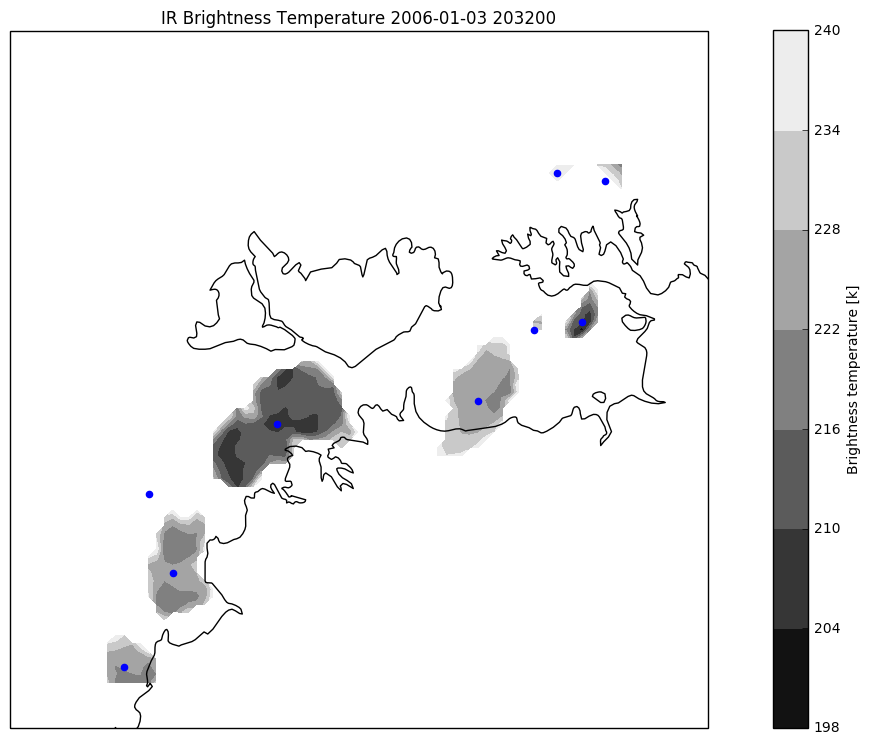

In [55]:
# Make image to where 1 = convective, 0 = not convective
blobs = deepcopy(data_masked)
blobs[~blobs.mask] = 1
blobs[blobs.mask] = 0
blobs.mask = False

# Get locations of blobs
blobs_labels, num_blobs = ndimage.measurements.label(blobs)
locs = ndimage.measurements.center_of_mass(blobs, blobs_labels, range(2, num_blobs))
List = [(elem2, elem1) for elem1, elem2 in locs]
lat_points = []
lon_points = []
for element in List:  
    lat_points.append(lat_gridded[element[1], element[0]])
    lon_points.append(lon_gridded[element[1], element[0]])
# Label 0 = masked data, 1 = background, clusters start at label 2
print('N = ' + str(num_blobs-2))
print('Locations: ')
print(List)

# Plot the blobs
figure = plt.figure(figsize=(17,9))
plt.subplot(211)
plt.imshow(blobs_labels, cmap='spectral')
plt.title('Blob labels')
plt.axis('off')
plt.xlim((100, 200))
plt.ylim((50, 150))
plt.xlabel('X [5 km]')
plt.ylabel('Y [5 km]')

plt.subplot(212)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
print(lat_gridded.shape)
handle = plt.contourf(lon_gridded, lat_gridded, 
                      data_masked, cmap=plt.get_cmap('gray'))
plt.scatter(lon_points, lat_points, color='b')
plt.title('IR Brightness Temperature '
          + str(year)
          + '-'
          + str(day_str)
          + '-'
          + str(month_str)
          + ' '
          + seconds_to_midnight_to_string(Time[index]))
cbar = plt.colorbar(handle)
cbar.set_label('Brightness temperature [k]')
plt.xlim((129, 133))
plt.ylim((-14, -10))
plt.xlabel('X [5 km]')
plt.ylabel('Y [5 km]')

## Calculate SCAI N/Nmax * D/L

N = number of clusters
Nmax = theoretical maximum number of clusters
D = product of distances between cells
L = characteristic length of domain (about 350 km here)

Tobin et al. (2012) show that N is sufficient to categorize degree of aggregation,
SCAI depends on domain size and on resolution, N does not.

Expected pairs: 36.0
4900.0


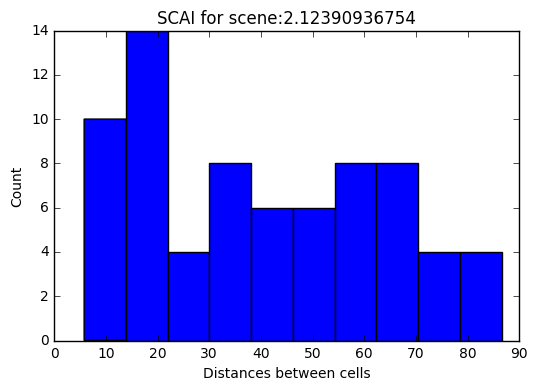

In [56]:
L = 350.0
a = 5.0
Nmax = pow((L/a),2)
print('Expected pairs: ' + str((num_blobs-2)*(num_blobs-3)/2))
distances = []
for point1 in List:
    for point2 in List:
        if(point1 != point2):
            d = math.sqrt(pow(point1[0]-point2[0],2) + pow(point1[1]-point2[1],2))
            distances.append(d)
            
n = (num_blobs-2)*(num_blobs-3)/2
d1 = 1/float(n)*np.sum(distances*5)
print(Nmax)
scai = ((num_blobs-2))/Nmax*d1/(L)*1000

plt.figure
plt.hist(distances)
plt.xlabel('Distances between cells')
plt.ylabel('Count')
plt.title('SCAI for scene:' + str(scai))


## Make NetCDF for time period

In [ ]:
N = []
years = []
days = []
months = []
hours = []
minutes = []
d1 = []
year = 2006
j = 0
k = 0
for satellite_file in file_list:
    cdf_data = Dataset(satellite_file, mode='r')
 
    # Load lat, lon, and time parameters
    Latitude = cdf_data.variables['latitude']
    Longitude = cdf_data.variables['longitude']
    Time = cdf_data.variables['image_times']
    NumPixels = cdf_data.variables['image_numpix']
    
    for i in range(0, len(NumPixels)):    
        # Load brightness temperature
        IRBrightness = cdf_data.variables['temperature_ir']
        
        # Get Lat and Lon for specific frame
        Lat = Latitude[(int(i)*int(NumPixels[i])):(int(i+1)*int(NumPixels[i])-1)]
        Lon = Longitude[(int(i)*int(NumPixels[i])):(int(i+1)*int(NumPixels[i])-1)]
        plt.clf()
        m = Basemap(width=500000, height=500000,
                    resolution='l', projection='stere',
                    lat_0=cpol_latitude,
                    lon_0=cpol_longitude)

        xi, yi = m(Lon, Lat)
        darwin_x, darwin_y = m(cpol_latitude, cpol_longitude)

        # Regrid data to 2D
        x,y = np.meshgrid(np.arange(min(xi),max(xi),5000),np.arange(min(yi),max(yi),5000))

        index = j
        data = IRBrightness[(int(i)*int(NumPixels[i])):(int(i+1)*int(NumPixels[i])-1)]
        data_gridded = interpolate.griddata((xi,yi), data, (x,y))
        lat_gridded = interpolate.griddata((xi,yi), Lat, (x,y))
        lon_gridded = interpolate.griddata((xi,yi), Lon, (x,y))
        
        masked_region = np.logical_or(np.logical_or(lat_gridded > cpol_latitude+1.5,
                                                    lat_gridded < cpol_latitude-1.5),
                                      np.logical_or(lon_gridded < cpol_longitude-1.5,
                                                    lon_gridded > cpol_longitude+1.5))
        masked_region = np.logical_or(masked_region, data_gridded > 240)
        data_masked = np.ma.array(data_gridded)
        data_masked = np.ma.masked_where(masked_region, data_gridded)
        
        # Make image to where 1 = convective, 0 = not convective
        blobs = deepcopy(data_masked)
        blobs[~blobs.mask] = 1
        blobs[blobs.mask] = 0
        blobs.mask = False
        blobs_labels, num_blobs = ndimage.measurements.label(blobs)
        locs = ndimage.measurements.center_of_mass(blobs, blobs_labels, range(2, num_blobs))

        # Label 0 = masked data, 1 = background, clusters start at label 2

        List = [(elem2, elem1) for elem1, elem2 in locs]
        N.append(num_blobs-2)
        
        distances = []
        for point1 in List:
            for point2 in List:
                if(point1 != point2):
                    d = math.sqrt(pow(point1[0]-point2[0],2) + pow(point1[1]-point2[1],2))
                    distances.append(d)
           
        n = (num_blobs-2)*(num_blobs-3)/2
        if(n > 0):
            d1.append(1/float(n)*np.sum(distances))
        else:
            d1.append(float('nan'))
            
        years.append(year)
        days.append(time_list[k].day)
        months.append(time_list[k].month)
        h, m = seconds_to_midnight_to_hm(Time[i])
        hours.append(h)
        minutes.append(m)
        j = j + 1  
    
        if(j % 100 == 0):
            print(j)
    k = k + 1

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in greater


In [ ]:
# Make netCDF file
out_netcdf = Dataset('num_clusters.cdf', mode='w')            
out_netcdf.createDimension('time', len(N))
print(len(N))

groups_file = out_netcdf.createVariable('N', 'i4', ('time',))
groups_file.long_name = 'Number of convective clusters'
groups_file.units = '#'
groups_file[:] = N

d1_file = out_netcdf.createVariable('d1', 'f4', ('time',))
d1_file.long_name = 'Distance between clusters'
d1_file.units = '#'
d1_file[:] = d1

years_file = out_netcdf.createVariable('year', int, ('time',))
years_file.long_name = 'Year'
years_file.units = 'YYYY'
years_file[:] = year

month_file = out_netcdf.createVariable('month',  int, ('time',))
month_file.long_name = 'Month'
month_file.units = 'MM'
month_file[:] = months

day_file = out_netcdf.createVariable('day', int, ('time',))
day_file.long_name = 'Day'
day_file.units = 'DD'
day_file[:] = days

hour_file = out_netcdf.createVariable('hour', int, ('time',))
hour_file.long_name = 'Hour'
hour_file.units = 'HH'
hour_file[:] = hours

minute_file = out_netcdf.createVariable('minute', int, ('time',))
minute_file.long_name = 'Hour'
minute_file.units = 'MM'
minute_file[:] = minutes

out_netcdf.close()    

## Plot aggregation index as a function of time

In [ ]:
CY_cdf = Dataset('/home/rjackson/data/num_clusters.cdf', mode='r')

classification = CY_cdf.variables['d1'][:]
year = CY_cdf.variables['year'][:]
month = CY_cdf.variables['month'][:]
day = CY_cdf.variables['day'][:]
hour = CY_cdf.variables['hour'][:]
minute = CY_cdf.variables['minute'][:]
print(hour[0:50])

date_array = []
for i in range(0,len(year)):
    dat = datetime.datetime(year=int(year[i]),
                            month=int(month[i]),
                            day=int(day[i]),
                            hour=int(hour[i]),
                            minute=int(minute[i]),)
    date_array.append(dat)
CY_cdf.close()

plt.figure(figsize=(20,5))
plt.plot_date(dates.date2num(date_array[250:-400]), classification[250:-400])